# Arxiv Dataset Clustering
This notebook aims to cluster scholarly articles from the Arxiv dataset.

# Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

## Load and Preview Data

In [2]:
input_file = '../data/data_preprocessed.csv'
df = pd.read_csv(input_file)
df.head()

,categories,update_date,text
0,hep-ph,2008-11-26,calculation prompt diphoton production cross s...
1,math.CO cs.CG,2008-12-13,sparsity certifying graph decomposition descri...
2,physics.gen-ph,2008-01-13,evolution earth moon system dark matter field ...
3,math.CO,2007-05-23,determinant stirling cycle number count unlabe...
4,math.CA math.FA,2013-10-15,dyadic lambda alpha lambda alpha paper compute...


## Text Vectorization

In [4]:
def vectorize_text(df):
    # Replace NaN values in the 'concat' column with empty strings
    df['text'] = df['text'].fillna('')
    # Instantiate TfidfVectorizer
    vectorizer = TfidfVectorizer(max_features=1000)
    X = vectorizer.fit_transform(df['text'])
    return X, vectorizer

tfidf_matrix, vectorizer = vectorize_text(df)

## Dimensionality Reduction

In [5]:
def reduce_dimensionality(X):
    svd = TruncatedSVD(n_components=50, random_state=42)
    X_reduced = svd.fit_transform(X)
    return X_reduced

X_reduced = reduce_dimensionality(tfidf_matrix)

## Visual Inspection using t-SNE

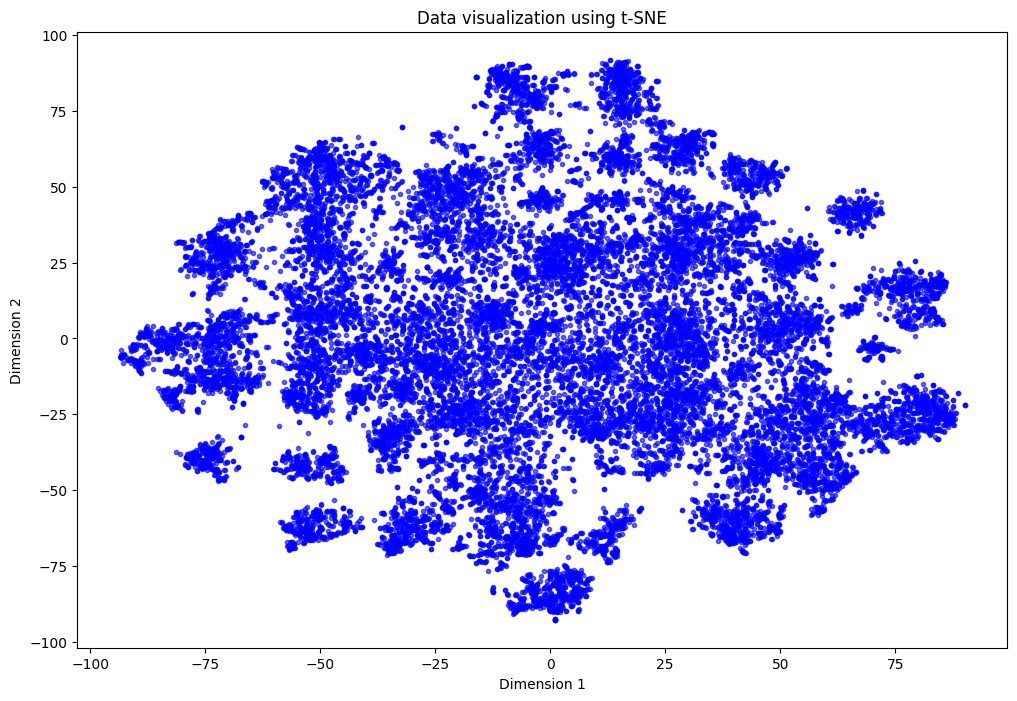

In [7]:
def visualize_tsne(X):
    # Taking a random sample of 1% of the data
    sample_indices = np.random.choice(X.shape[0], int(0.01 * X.shape[0]), replace=False)
    X_sample = X[sample_indices]

    # Instantiating and fitting t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(X_sample)

    # Plotting the t-SNE features
    plt.figure(figsize=(12, 8))
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], marker='.', c='blue', alpha=0.6)
    plt.title('Data visualization using t-SNE')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.show()


visualize_tsne(X_reduced)

## Determine Optimal Clusters using Silhouette Score

For n_clusters=2, The Silhouette Coefficient is 0.05134725153243875
For n_clusters=3, The Silhouette Coefficient is 0.05793029647833684
For n_clusters=4, The Silhouette Coefficient is 0.04349410140931254
For n_clusters=5, The Silhouette Coefficient is 0.05315104832741804
For n_clusters=6, The Silhouette Coefficient is 0.04617903294679643
For n_clusters=7, The Silhouette Coefficient is 0.0657298883094553
For n_clusters=8, The Silhouette Coefficient is 0.04882339343139162
For n_clusters=9, The Silhouette Coefficient is 0.05891611768824897
For n_clusters=10, The Silhouette Coefficient is 0.04713946658340888
For n_clusters=11, The Silhouette Coefficient is 0.039812210771050266
For n_clusters=12, The Silhouette Coefficient is 0.04634972231682544
For n_clusters=13, The Silhouette Coefficient is 0.04262313934619842
For n_clusters=14, The Silhouette Coefficient is 0.04282712802648614
For n_clusters=15, The Silhouette Coefficient is 0.04905459382916274
For n_clusters=16, The Silhouette Coeffici

C:\Users\moham\AppData\Local\Temp\ipykernel_18996\3457633382.py:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bx-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(range_clusters, silhouette_scores, 'bx-', color='red', linewidth=2, markersize=8, label='Silhouette Score'), plt.grid(True), plt.legend(loc='best', shadow=True, fontsize='medium', numpoints=1)


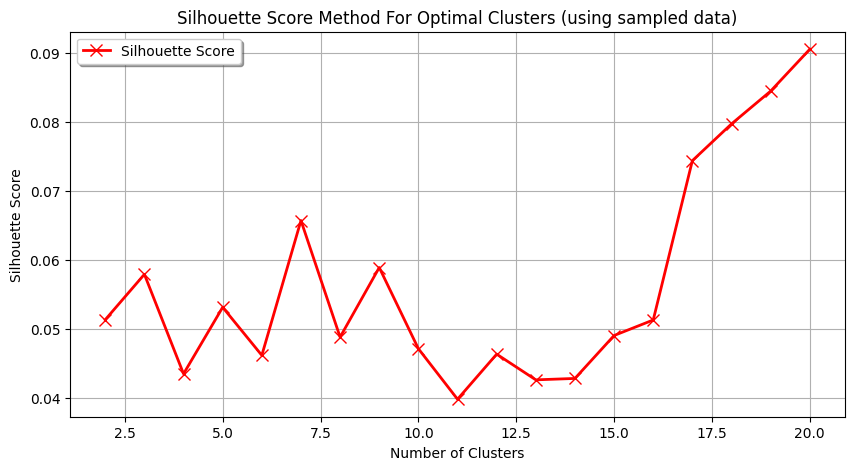

In [9]:
def optimal_clusters_silhouette(X):
    silhouette_scores = []
    range_clusters = range(2, 21)
    
    # Taking a random sample of 10% of the data
    sample_indices = np.random.choice(X.shape[0], int(0.01 * X.shape[0]), replace=False)
    X_sample = X[sample_indices]
    
    for n_cluster in range_clusters:
        kmeans = KMeans(n_clusters=n_cluster, n_init='auto', random_state=0).fit(X_sample)
        label = kmeans.labels_
        sil_coeff = silhouette_score(X_sample, label, metric='euclidean')
        silhouette_scores.append(sil_coeff)
        print(f"For n_clusters={n_cluster}, The Silhouette Coefficient is {sil_coeff}")

    # Plotting a bar graph to compare the results
    plt.figure(figsize=(10,5))
    plt.plot(range_clusters, silhouette_scores, 'bx-', linewidth=2, markersize=8, label='Silhouette Score'), plt.grid(True)
    plt.title('Silhouette Score Method For Optimal Clusters (using sampled data)')
    # plot x axis labels as integers
    plt.xticks(range_clusters, range_clusters)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.show()


optimal_clusters_silhouette(X_reduced)

## Determine Optimal Clusters

For n_clusters = 2, silhouette score is 0.05178185247654668)
For n_clusters = 2, Davies-Bouldin score is 4.460149690197701)
For n_clusters = 3, silhouette score is 0.03490379320541357)
For n_clusters = 3, Davies-Bouldin score is 3.883210268897875)
For n_clusters = 4, silhouette score is 0.04651134517319209)
For n_clusters = 4, Davies-Bouldin score is 3.559041033338664)
For n_clusters = 5, silhouette score is 0.05541737858179714)
For n_clusters = 5, Davies-Bouldin score is 3.302993225894646)
For n_clusters = 6, silhouette score is 0.0572421710804204)
For n_clusters = 6, Davies-Bouldin score is 3.066860097622602)
For n_clusters = 7, silhouette score is 0.06588340313610308)
For n_clusters = 7, Davies-Bouldin score is 3.0124478458595747)
For n_clusters = 8, silhouette score is 0.06960213283395988)
For n_clusters = 8, Davies-Bouldin score is 2.7926009213561307)
For n_clusters = 9, silhouette score is 0.034970732454317234)
For n_clusters = 9, Davies-Bouldin score is 2.796318039834001)
For n_

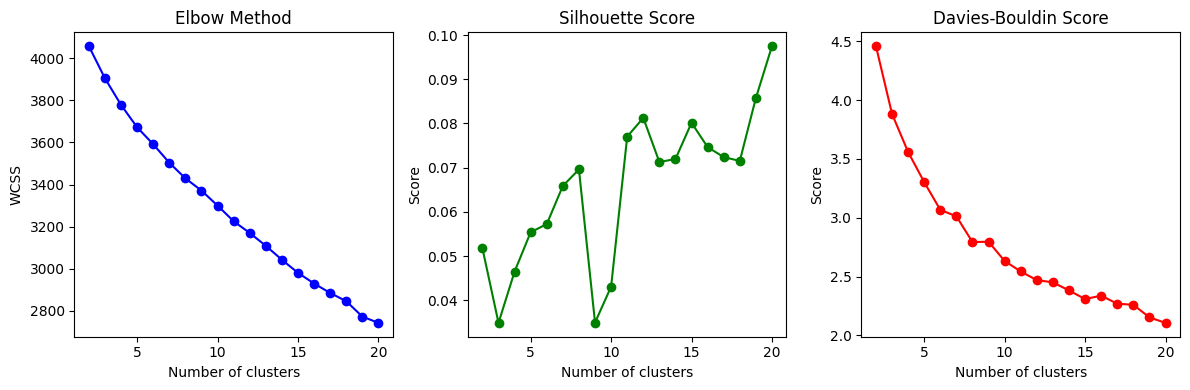

In [10]:
def determine_optimal_clusters(X):
    wcss = []
    silhouette_scores = []
    davies_bouldin_scores = []

    # Taking a random sample of 10% of the data
    sample_indices = np.random.choice(X.shape[0], int(0.01 * X.shape[0]), replace=False)
    X_sample = X[sample_indices]

    # Define a range of clusters to test
    cluster_range = range(2, 21)

    for i in cluster_range:
        kmeans = KMeans(n_clusters=i, n_init=10, random_state=0)
        kmeans.fit(X_sample)
        wcss.append(kmeans.inertia_)

        # Calculate silhouette score
        silhouette_avg = silhouette_score(X_sample, kmeans.labels_)
        silhouette_scores.append(silhouette_avg)

        # Calculate Davies-Bouldin index
        davies_bouldin_avg = davies_bouldin_score(X_sample, kmeans.labels_)
        davies_bouldin_scores.append(davies_bouldin_avg)

        # Print the score for each cluster
        print("For n_clusters = {}, silhouette score is {})".format(i, silhouette_avg))
        print("For n_clusters = {}, Davies-Bouldin score is {})".format(i, davies_bouldin_avg))


    # Plot the elbow method
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.plot(cluster_range, wcss, marker='o', linestyle='-', color='b')
    plt.title('Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')

    # Plot Silhouette Score
    plt.subplot(1, 3, 2)
    plt.plot(cluster_range, silhouette_scores, marker='o', linestyle='-', color='g')
    plt.title('Silhouette Score')
    plt.xlabel('Number of clusters')
    plt.ylabel('Score')

    # Plot Davies-Bouldin Score
    plt.subplot(1, 3, 3)
    plt.plot(cluster_range, davies_bouldin_scores, marker='o', linestyle='-', color='r')
    plt.title('Davies-Bouldin Score')
    plt.xlabel('Number of clusters')
    plt.ylabel('Score')

    plt.tight_layout()
    plt.show()

# Call the function to determine optimal clusters
determine_optimal_clusters(X_reduced)

## Apply Clustering

In [11]:
def apply_clustering(X, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=0)
    clusters = kmeans.fit_predict(X)
    return clusters

# Based on the Elbow Method plot, choose an optimal number for clusters
optimal_clusters = 8  # Adjusted based on observation.
df['cluster'] = apply_clustering(X_reduced, optimal_clusters)

## Visualizing Clusters

d:\ML-trend-analysis\Scientific-Trend-Analysis\env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\ML-trend-analysis\Scientific-Trend-Analysis\env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\ML-trend-analysis\Scientific-Trend-Analysis\env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


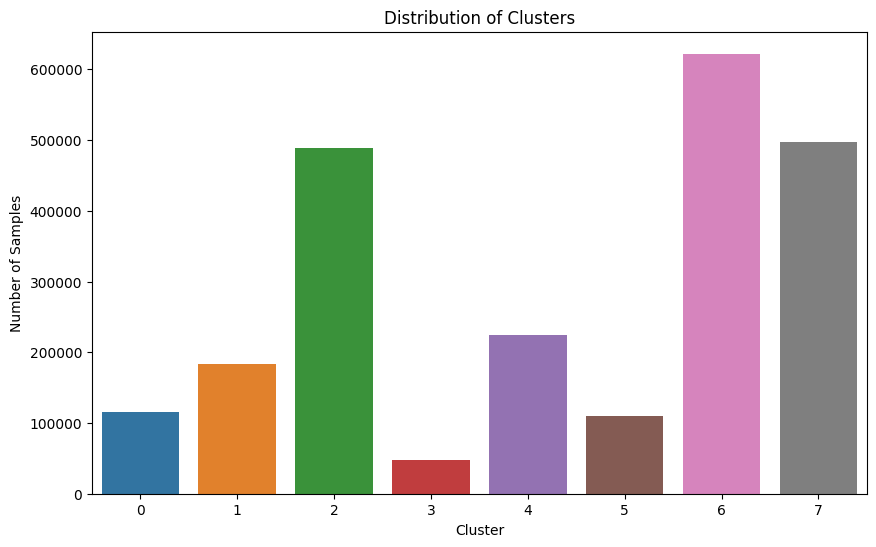

In [12]:
def plot_clusters(df):
    plt.figure(figsize=(10,6))
    sns.countplot(x='cluster', data=df)
    plt.title('Distribution of Clusters')
    plt.xlabel('Cluster')
    plt.ylabel('Number of Samples')
    plt.show()

plot_clusters(df)

## Save Results

In [ ]:
output_file = '../data/data_clustered.csv'
df.to_csv(output_file, index=False)
